<a href="https://colab.research.google.com/github/aiaaee/California_Housing/blob/main/CaliforniaHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset , DataLoader
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data = fetch_california_housing()
# In dataset as_frame is false . it means that we need to create Dataset and do data and target combination
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)

(16512, 8) (16512,)
(4128, 8) (4128,)


In [ ]:
X_train

array([[-0.326196  ,  0.34849025, -0.17491646, ...,  0.05137609,
        -1.3728112 ,  1.27258656],
       [-0.03584338,  1.61811813, -0.40283542, ..., -0.11736222,
        -0.87669601,  0.70916212],
       [ 0.14470145, -1.95271028,  0.08821601, ..., -0.03227969,
        -0.46014647, -0.44760309],
       ...,
       [-0.49697313,  0.58654547, -0.60675918, ...,  0.02030568,
        -0.75500738,  0.59946887],
       [ 0.96545045, -1.07984112,  0.40217517, ...,  0.00707608,
         0.90651045, -1.18553953],
       [-0.68544764,  1.85617335, -0.85144571, ..., -0.08535429,
         0.99543676, -1.41489815]])

In [ ]:
# Create a custom PyTorch dataset

toTensorTransform = transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))
class CaliforniaHousingDataset(Dataset):
    def __init__(self, features, targets, transform=None, target_transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y

In [ ]:
# Create instances of the custom dataset
train_dataset = CaliforniaHousingDataset(X_train, y_train, transform=toTensorTransform,
                                         target_transform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)))

test_dataset = CaliforniaHousingDataset(X_test, y_test, transform=toTensorTransform,
                                        target_transform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)))

# Create PyTorch data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
for data, target in train_loader:
    print(target.size())
    break

torch.Size([64, 1])


In [71]:
class NeuralNet(nn.Module):
  def __init__(self , input_feature , hidden_feature , output_feature , *args , **kwargs ):
    super().__init__(*args , **kwargs )
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_feature , hidden_feature)
    self.r1 = nn.GELU()
    self.fc2 = nn.Linear(hidden_feature , hidden_feature)
    self.r2 = nn.GELU()
    self.fc3 = nn.Linear(hidden_feature , output_feature)
    self.r3 = nn.GELU()


  def forward(self , x ):
      output = self.flatten(x)
      output = self.r1(self.fc1(x))
      output = self.r2(self.fc2(output))
      return self.r3(self.fc3(output))


In [72]:
model = NeuralNet(8 , 200 , 1 )
model

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8, out_features=200, bias=True)
  (r1): GELU(approximate='none')
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (r2): GELU(approximate='none')
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (r3): GELU(approximate='none')
)

In [73]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=1e-3)

In [74]:
train_history = []
validation_history = []
num_epochs = 30
for epoch in range(num_epochs):

    model.train()
    losses = []

    with tqdm(train_loader, leave=False) as bar:
        bar.set_description(f"[Epoch: {epoch + 1}/{num_epochs}]")

        for batch_idx, (data, target) in enumerate(bar):

            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            bar.set_postfix(avg_epoch_loss=f"{sum(losses)/len(losses):.4f}")
    train_history.append(sum(losses)/len(losses))

    model.eval()
    running_testloss = 0.0

    with torch.no_grad():
        for i, (test_data, test_label) in enumerate(test_loader):
            test_output = model(test_data)
            vloss = criterion(test_output, test_label)
            running_testloss += vloss.item()
        avg_vloss = running_testloss / (i + 1)
        validation_history.append(avg_vloss)
        if epoch % 10 == 9:
            print(f'Epoch [{epoch + 1}/{num_epochs}]: loss train: {sum(losses)/len(losses):.3f}, validation: {avg_vloss:.3f}')

Epoch [10/30]: loss train: 0.308, validation: 0.314


Epoch [20/30]: loss train: 0.285, validation: 0.295


Epoch [30/30]: loss train: 0.270, validation: 0.292


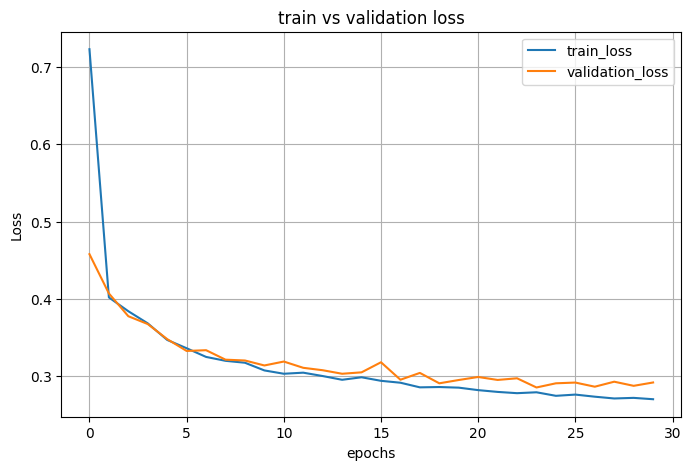

In [75]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_history, label="train_loss")
ax.plot(validation_history, label="validation_loss")
ax.set_title("train vs validation loss")
ax.set_ylabel('Loss')
ax.set_xlabel('epochs')
ax.grid()
ax.legend(loc='upper right')